In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import numpy as np
import skimage
import cv2

from PIL import Image

cmap = matplotlib.cm.get_cmap('Greys')
cmap.set_bad(color="w", alpha=0.0)

colors=['lightcoral', 'cornflowerblue', 'gold', 'limegreen', 'fuchsia']

def attention_bbox_interpolation(im, bboxes, att):
    softmax = att
    assert len(softmax) == len(bboxes)

    img_h, img_w = im.shape[:2]
    opacity = np.zeros((img_h, img_w), np.float32)
    for bbox, weight in zip(bboxes, softmax):
        x1, y1, x2, y2 = bbox
        opacity[int(y1):int(y2), int(x1):int(x2)] = np.maximum(opacity[int(y1):int(y2), int(x1):int(x2)], weight * 3)
#         opacity[int(y1):int(y2), int(x1):int(x2)] -= weight
    opacity = np.minimum(opacity, 1)

    opacity = opacity[..., np.newaxis]
    
    vis_im = np.array(Image.fromarray(cmap(opacity, bytes=True), 'RGBA'))
    vis_im = vis_im.astype(im.dtype)
    vis_im = cv2.addWeighted(im, 0.2, vis_im, 0.8, 0)
    vis_im = vis_im.astype(im.dtype)
    
    return vis_im


def attention_grid_interpolation(im, att):
    softmax = np.reshape(att, (14, 14))
    opacity = skimage.transform.resize(softmax, im.shape[:2], order=3)
    opacity = opacity[..., np.newaxis]
    opacity = opacity*0.95+0.05

    vis_im = opacity*im + (1-opacity)*255
    vis_im = vis_im.astype(im.dtype)
    return vis_im

def visualize_pred(im_path, boxes, att_weights, labels):
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
    b,g,r,a = cv2.split(im)           # get b, g, r
    im = cv2.merge([r,g,b,a])

    M = min(len(boxes), len(att_weights))
    im_ocr_att = attention_bbox_interpolation(im, boxes[:M], att_weights[:M])
    
    # draw the bbox
    fig,ax = plt.subplots(1)
    ax.imshow(im_ocr_att)
    for i in range(len(boxes)):
        box = boxes[i]
        rect=patches.Rectangle(xy=(box[0],box[1]), width=box[2]-box[0], 
                               height=box[3]-box[1], linewidth=1, fill=False, edgecolor=colors[i])
        ax.add_patch(rect)
        ax.text(box[0],box[1], labels[i], bbox={'facecolor': colors[i], 'alpha': 0.5, 'pad': 2})
#         ax.text(box[0],box[1], ":".join(str(round(att_weights[i], 2)), style='italic', bbox={'facecolor': colors[i], 'alpha': 0.5, 'pad': 0})

In [25]:
weights =[[[0.0000, 0.0000, 0.0907, 0.2793, 0.2783, 0.1706, 0.1811],
         [0.0000, 0.0000, 0.1028, 0.4078, 0.2277, 0.1327, 0.1290],
         [0.2377, 0.1122, 0.0000, 0.1531, 0.1832, 0.2250, 0.0888],
         [0.2398, 0.1205, 0.0613, 0.0000, 0.2720, 0.1833, 0.1231],
         [0.2820, 0.0776, 0.0768, 0.2754, 0.0000, 0.1368, 0.1515],
         [0.2457, 0.0719, 0.1194, 0.2728, 0.1638, 0.0000, 0.1264],
         [0.1681, 0.0636, 0.0773, 0.2547, 0.2698, 0.1664, 0.0000]]]
results = []
b = weights[0]
for i in range(len(b)):
  total = 0
  for j in range(len(b)):
    total += b[i][j]
    total += b[j][i]
  result = total / (2 * len(b))
  results.append(result)

proposals = [[[  2.5572,   0.0000, 311.9272, 500.4232,   1.0000,   0.9886],
         [447.3408,  44.1731, 511.0000, 244.7408,  41.0000,   0.9655],
         [305.5323, 119.1194, 424.6187, 253.2900,  45.0000,   0.9190],
         [230.3045,  12.6292, 472.6638, 404.6172,   1.0000,   0.8896],
         [252.4186, 104.8849, 511.0000, 510.1856,  61.0000,   0.8886],
         [328.4287, 281.0542, 433.4053, 425.7080,  46.0000,   0.8197],
         [270.9013,   1.9133, 507.1116, 152.7887,   1.0000,   0.6678]]]

proposal = proposals[0]
bboxes = []
for i in range(len(proposal)):
    bboxes.append(proposal[i][:4])

print(bboxes)

weight_att = np.array(results)
bboxes_ppl = np.array(bboxes)

inds = np.argsort(-weight_att)
soted_bboxes = bboxes_ppl[inds]
sorted_weights = weight_att[inds]

[[2.5572, 0.0, 311.9272, 500.4232], [447.3408, 44.1731, 511.0, 244.7408], [305.5323, 119.1194, 424.6187, 253.29], [230.3045, 12.6292, 472.6638, 404.6172], [252.4186, 104.8849, 511.0, 510.1856], [328.4287, 281.0542, 433.4053, 425.708], [270.9013, 1.9133, 507.1116, 152.7887]]


In [26]:
results, proposals, soted_bboxes, sorted_weights

([0.15523571428571428,
  0.10327142857142858,
  0.10916428571428571,
  0.18879285714285715,
  0.1710642857142857,
  0.14391428571428572,
  0.12855714285714287],
 [[[2.5572, 0.0, 311.9272, 500.4232, 1.0, 0.9886],
   [447.3408, 44.1731, 511.0, 244.7408, 41.0, 0.9655],
   [305.5323, 119.1194, 424.6187, 253.29, 45.0, 0.919],
   [230.3045, 12.6292, 472.6638, 404.6172, 1.0, 0.8896],
   [252.4186, 104.8849, 511.0, 510.1856, 61.0, 0.8886],
   [328.4287, 281.0542, 433.4053, 425.708, 46.0, 0.8197],
   [270.9013, 1.9133, 507.1116, 152.7887, 1.0, 0.6678]]],
 array([[230.3045,  12.6292, 472.6638, 404.6172],
        [252.4186, 104.8849, 511.    , 510.1856],
        [  2.5572,   0.    , 311.9272, 500.4232],
        [328.4287, 281.0542, 433.4053, 425.708 ],
        [270.9013,   1.9133, 507.1116, 152.7887],
        [305.5323, 119.1194, 424.6187, 253.29  ],
        [447.3408,  44.1731, 511.    , 244.7408]]),
 array([0.18879286, 0.17106429, 0.15523571, 0.14391429, 0.12855714,
        0.10916429, 0.103271

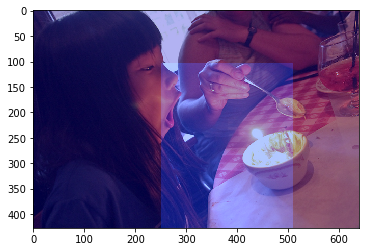

In [31]:
visualize_pred('/home/fanfu/newdisk/dataset/coco/2014/val2014/COCO_val2014_000000060623.jpg', soted_bboxes[1:2], sorted_weights[1:2])

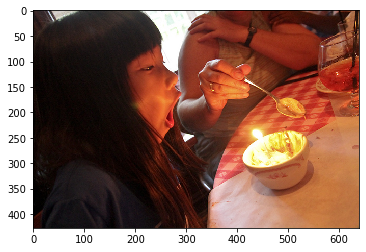

In [18]:
im = cv2.imread('/home/fanfu/newdisk/dataset/coco/2014/val2014/COCO_val2014_000000060623.jpg')
im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
b,g,r,a = cv2.split(im)           # get b, g, r
im = cv2.merge([r,g,b,a])
plt.imshow(im)

In [73]:
image_path = '/home/fanfu/newdisk/dataset/coco/2014/val2014/COCO_val2014_000000060623.jpg'
# img_id = 60623
img_id = 334321
proposal_h5 = 'data/coco/coco_detection.h5'
input_dic = 'data/coco/dic_coco.json'

In [16]:
from misc.dataloader_hdf import HDFSingleDataset
import json
import copy
import os

In [11]:
dataloader_ppls = HDFSingleDataset(proposal_h5)
info = json.load(open(input_dic))

In [12]:
info['images']

[{'split': 'test',
  'file_path': 'val2014/COCO_val2014_000000391895.jpg',
  'id': 391895},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000522418.jpg',
  'id': 522418},
 {'split': 'val',
  'file_path': 'val2014/COCO_val2014_000000184613.jpg',
  'id': 184613},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000318219.jpg',
  'id': 318219},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000554625.jpg',
  'id': 554625},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000397133.jpg',
  'id': 397133},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000574769.jpg',
  'id': 574769},
 {'split': 'test',
  'file_path': 'val2014/COCO_val2014_000000060623.jpg',
  'id': 60623},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000309022.jpg',
  'id': 309022},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000005802.jpg',
  'id': 5802},
 {'split': 'train',
  'file_path': 'val2014/COCO_val2014_000000222564.jpg',
 

In [96]:
def get_ppl(image_id):
    for ix in range(len(info['images'])):
        if info['images'][ix]['id'] == image_id:
            img_path = info['images'][ix]['file_path']
            proposal_item =copy.deepcopy(dataloader_ppls[ix])
            num_proposal = int(proposal_item['dets_num'])
            num_nms = int(proposal_item['nms_num'])
            proposals = proposal_item['dets_labels']
            proposals = proposals.squeeze()[:num_nms, :]
            break
    return proposals, num_nms, img_path

In [94]:
proposals, num_nms = get_ppl(img_id)

In [95]:
proposals[:,:4]

array([[133.13978577, 105.78314972, 422.92807007, 342.79299927],
       [258.69116211,   4.12366676, 314.88128662,  69.55408478],
       [ 76.11714172,  19.32497787, 284.78656006, 298.90698242],
       [  0.        , 132.37269592, 251.58074951, 352.71228027],
       [155.00843811,  16.34574699, 284.70956421, 141.11198425],
       [255.98344421,   9.62212467, 336.03912354,  58.2383194 ],
       [221.77886963,  89.7460556 , 266.80871582, 140.23132324],
       [534.56958008, 257.28790283, 550.77368164, 265.36148071],
       [296.49145508,  29.86752319, 338.55178833,  54.57820511],
       [254.78060913,  25.16952896, 291.20874023,  67.72980499]])

"image_id": 60623,
    "caption": "a [ woman ] sitting at a [ table ] with a [ bowl ] of food "
    a [ woman ] is eating a piece of food 

In [77]:
print(os.path.join("/home/fanfu/newdisk/Dropbox/city_session/individual project/project/relationNBT/save/attention_weights/", str(img_id) + '.json'))
with open(os.path.join("/home/fanfu/newdisk/Dropbox/city_session/individual project/project/relationNBT/save/attention_weights/", str(img_id) + '.json'),'r') as f:
    data_weights = json.load(f)
for i in range(len(data_weights)):
    for j in range(len(data_weights[0])):
        data_weights[i][j] = round(data_weights[i][j], 4)
print(data_weights)
b = np.array(data_weights)[:num_nms, :num_nms]
print(b)
# weights =[[[0.0000, 0.0000, 0.0907, 0.2793, 0.2783, 0.1706, 0.1811],
#          [0.0000, 0.0000, 0.1028, 0.4078, 0.2277, 0.1327, 0.1290],
#          [0.2377, 0.1122, 0.0000, 0.1531, 0.1832, 0.2250, 0.0888],
#          [0.2398, 0.1205, 0.0613, 0.0000, 0.2720, 0.1833, 0.1231],
#          [0.2820, 0.0776, 0.0768, 0.2754, 0.0000, 0.1368, 0.1515],
#          [0.2457, 0.0719, 0.1194, 0.2728, 0.1638, 0.0000, 0.1264],
#          [0.1681, 0.0636, 0.0773, 0.2547, 0.2698, 0.1664, 0.0000]]]
results = []
# b = weights[0]
for i in range(len(b)):
  total = 0
  for j in range(len(b)):
    total += b[i][j]
    total += b[j][i]
  result = total / (2 * len(b))
  results.append(result)
print(results)
weight_att = np.array(results)
# bboxes_ppl = np.array(bboxes)
bboxes_ppl = proposals[:,:4]

inds = np.argsort(-weight_att)
soted_bboxes = bboxes_ppl[inds]
sorted_weights = weight_att[inds]
proposals_bboxes = proposals[inds]

/home/fanfu/newdisk/Dropbox/city_session/individual project/project/relationNBT/save/attention_weights/334321.json
[[0.065, 0.0408, 0.16, 0.1349, 0.0568, 0.0378, 0.1821, 0.0554, 0.034, 0.0376, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196], [0.1492, 0.0177, 0.1092, 0.1865, 0.0542, 0.0179, 0.0233, 0.0625, 0.0244, 0.092, 0.0254, 0.0343, 0.0206, 0.0403, 0.0199, 0.0214, 0.0189, 0.0255, 0.0284, 0.0284], [0.1568, 0.0376, 0.0374, 0.1797, 0.0786, 0.0426, 0.0373, 0.0228, 0.0441, 0.0989, 0.0209, 0.0209, 0.0209, 0.0209, 0.0209, 0.0209, 0.0212, 0.0191, 0.0777, 0.0206], [0.1879, 0.0423, 0.1599, 0.0537, 0.0914, 0.0468, 0.0507, 0.0151, 0.0241, 0.189, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139], [0.117, 0.0367, 0.1262, 0.209, 0.0299, 0.0343, 0.033, 0.0897, 0.0489, 0.0725, 0.0203, 0.0326, 0.0189, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187], [0.1419, 0.0179, 0.1231, 0.1952, 0.0486, 0.0151, 0.0218, 0.0569, 0.0246, 0.0606, 0.

In [78]:
results, soted_bboxes, sorted_weights, proposals_bboxes

([0.12164499999999998,
  0.054015,
  0.09459000000000001,
  0.12157499999999999,
  0.067675,
  0.05293499999999999,
  0.06597,
  0.06035999999999999,
  0.04906499999999999,
  0.07565],
 array([[133.13978577, 105.78314972, 422.92807007, 342.79299927],
        [  0.        , 132.37269592, 251.58074951, 352.71228027],
        [ 76.11714172,  19.32497787, 284.78656006, 298.90698242],
        [254.78060913,  25.16952896, 291.20874023,  67.72980499],
        [155.00843811,  16.34574699, 284.70956421, 141.11198425],
        [221.77886963,  89.7460556 , 266.80871582, 140.23132324],
        [534.56958008, 257.28790283, 550.77368164, 265.36148071],
        [258.69116211,   4.12366676, 314.88128662,  69.55408478],
        [255.98344421,   9.62212467, 336.03912354,  58.2383194 ],
        [296.49145508,  29.86752319, 338.55178833,  54.57820511]]),
 array([0.121645, 0.121575, 0.09459 , 0.07565 , 0.067675, 0.06597 ,
        0.06036 , 0.054015, 0.052935, 0.049065]),
 array([[1.33139786e+02, 1.05783150

    "image_id": 334321,
    RelationshipNBT: "caption": "a [ man ] sitting on a [ bench ] with a [ dog ] "
    NBT: "caption": "a white [ dog ] is sitting on a [ bench ] "

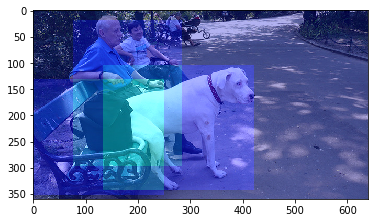

In [84]:
visualize_pred('/home/fanfu/newdisk/dataset/coco/2014/val2014/COCO_val2014_000000334321.jpg', soted_bboxes[:3], sorted_weights[:3])

In [67]:
from pycocotools.coco import COCO

annFile = "/home/fanfu/newdisk/dataset/coco/2014/annotations/instances_val2014.json"
coco=COCO(annFile)

loading annotations into memory...
Done (t=4.62s)
creating index...
index created!


In [209]:
# catIds = coco.getImgIds(img_id)
cats = coco.loadCats(coco.getCatIds())
categories = {}
for i in range(len(cats)):
    categories[i + 1] = cats[i]['name']

In [210]:
categories

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'stop sign',
 13: 'parking meter',
 14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 25: 'backpack',
 26: 'umbrella',
 27: 'handbag',
 28: 'tie',
 29: 'suitcase',
 30: 'frisbee',
 31: 'skis',
 32: 'snowboard',
 33: 'sports ball',
 34: 'kite',
 35: 'baseball bat',
 36: 'baseball glove',
 37: 'skateboard',
 38: 'surfboard',
 39: 'tennis racket',
 40: 'bottle',
 41: 'wine glass',
 42: 'cup',
 43: 'fork',
 44: 'knife',
 45: 'spoon',
 46: 'bowl',
 47: 'banana',
 48: 'apple',
 49: 'sandwich',
 50: 'orange',
 51: 'broccoli',
 52: 'carrot',
 53: 'hot dog',
 54: 'pizza',
 55: 'donut',
 56: 'cake',
 57: 'chair',
 58: 'couch',
 59: 'potted plant',
 60: 'bed',
 61: 'dining table',
 62: 'toilet',
 63: 'tv',
 64: 'laptop',
 65: 'mo

In [197]:
def visual_att(image_id, topk):
    proposals, num_nms, img_path = get_ppl(image_id)
#     print(os.path.join("/home/fanfu/newdisk/Dropbox/city_session/individual project/project/relationNBT/save/attention_weights/", str(img_id) + '.json'))
    with open(os.path.join("/home/fanfu/newdisk/Dropbox/city_session/individual project/project/relationNBT/save/attention_weights/", str(image_id) + '.json'),'r') as f:
        data_weights = json.load(f)
    for i in range(len(data_weights)):
        for j in range(len(data_weights[0])):
            data_weights[i][j] = round(data_weights[i][j], 4)
#     print(data_weights)
    b = np.array(data_weights)[:num_nms, :num_nms]
    print(b)
    # weights =[[[0.0000, 0.0000, 0.0907, 0.2793, 0.2783, 0.1706, 0.1811],
    #          [0.0000, 0.0000, 0.1028, 0.4078, 0.2277, 0.1327, 0.1290],
    #          [0.2377, 0.1122, 0.0000, 0.1531, 0.1832, 0.2250, 0.0888],
    #          [0.2398, 0.1205, 0.0613, 0.0000, 0.2720, 0.1833, 0.1231],
    #          [0.2820, 0.0776, 0.0768, 0.2754, 0.0000, 0.1368, 0.1515],
    #          [0.2457, 0.0719, 0.1194, 0.2728, 0.1638, 0.0000, 0.1264],
    #          [0.1681, 0.0636, 0.0773, 0.2547, 0.2698, 0.1664, 0.0000]]]
    results = []
    # b = weights[0]
    for i in range(len(b)):
      total = 0
      for j in range(len(b)):
        total += b[i][j]
        total += b[j][i]
      result = total / (2 * len(b))
      results.append(result)
    print(results)
    
    weight_att = np.array(results)
    # bboxes_ppl = np.array(bboxes)
    bboxes_ppl = proposals[:,:4]

    inds = np.argsort(-weight_att)
    soted_bboxes = bboxes_ppl[inds]
    sorted_weights = weight_att[inds]
    proposals_bboxes = proposals[inds]
    print(proposals_bboxes)
    # get labels
    labels = []
    for i in range(topk):
#         print(proposals_bboxes[i][5])
        class_bbox = int(proposals_bboxes[i][4])
#         print(class_bbox)
        labels.append(categories[class_bbox] + ':' + str(round(sorted_weights[i],2)))
    visualize_pred(os.path.join('/home/fanfu/newdisk/dataset/coco/2014/', img_path), 
                   soted_bboxes[:topk], sorted_weights[:topk], labels)

[[0.065  0.0408 0.16   0.1349 0.0568 0.0378 0.1821 0.0554 0.034  0.0376]
 [0.1492 0.0177 0.1092 0.1865 0.0542 0.0179 0.0233 0.0625 0.0244 0.092 ]
 [0.1568 0.0376 0.0374 0.1797 0.0786 0.0426 0.0373 0.0228 0.0441 0.0989]
 [0.1879 0.0423 0.1599 0.0537 0.0914 0.0468 0.0507 0.0151 0.0241 0.189 ]
 [0.117  0.0367 0.1262 0.209  0.0299 0.0343 0.033  0.0897 0.0489 0.0725]
 [0.1419 0.0179 0.1231 0.1952 0.0486 0.0151 0.0218 0.0569 0.0246 0.0606]
 [0.2699 0.0323 0.0998 0.2153 0.0409 0.0195 0.0161 0.0688 0.0215 0.0518]
 [0.2443 0.0491 0.0375 0.0396 0.0369 0.0702 0.0538 0.0418 0.0423 0.0424]
 [0.1585 0.0341 0.1475 0.0886 0.0514 0.0357 0.0348 0.0697 0.0194 0.0393]
 [0.138  0.0349 0.1554 0.2681 0.0676 0.0331 0.0306 0.0666 0.019  0.0078]]
[0.12164499999999998, 0.054015, 0.09459000000000001, 0.12157499999999999, 0.067675, 0.05293499999999999, 0.06597, 0.06035999999999999, 0.04906499999999999, 0.07565]
[[1.33139786e+02 1.05783150e+02 4.22928070e+02 3.42792999e+02
  1.70000000e+01 9.96155918e-01]
 [0.00000

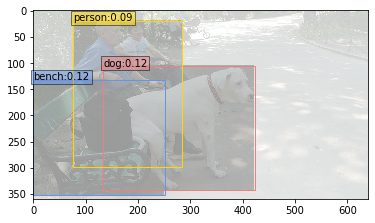

In [223]:
visual_att(334321, 3)

[[0.08   0.1106 0.2254 0.1027 0.0303 0.0707 0.1271]
 [0.2237 0.0297 0.118  0.041  0.026  0.1719 0.0442]
 [0.2121 0.1072 0.0536 0.0881 0.0654 0.0644 0.0655]
 [0.2603 0.1757 0.2062 0.0106 0.0172 0.1659 0.0393]
 [0.1856 0.1312 0.2641 0.0302 0.0202 0.0375 0.0482]
 [0.2084 0.1855 0.1513 0.0636 0.0314 0.0191 0.0393]
 [0.2831 0.1345 0.161  0.0386 0.0311 0.0272 0.0336]]
[0.1571428571428571, 0.10920714285714286, 0.13113571428571427, 0.0892857142857143, 0.06704285714285714, 0.08966428571428571, 0.07902142857142858]
[[360.37521362  25.18915939 478.30966187 371.64758301   1.
    0.999529  ]
 [553.00378418  74.24288177 594.68109131 202.97904968   1.
    0.99378103]
 [359.04190063 340.59103394 462.74038696 406.4788208   37.
    0.99666899]
 [424.8006897   86.2724762  461.16680908 207.19586182  28.
    0.70511121]
 [448.50314331  89.75318909 478.29763794 232.19508362  28.
    0.95780057]
 [559.05670166  93.02112579 588.68438721 141.32313538  27.
    0.69698387]
 [359.58987427  81.47647858 430.8355407

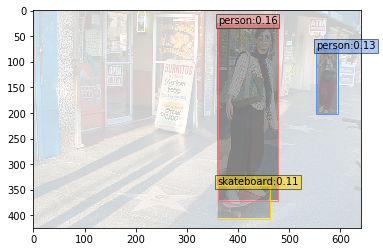

In [222]:
visual_att(216228, 3)